  # Test of MLP model
  
 
 


In [11]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter

from scipy.stats import randint as sp_randint
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import QuantileTransformer
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
from imblearn.keras import balanced_batch_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

  ### Definition of names for plots and files

In [3]:

date = '20191119'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v4/dfcrossmatches_prioritized_v4_withYSO_fromSimbad.csv'
features_file = '../ZTF_data/features20191119_withWISE.csv'

class_output = '../ZTF_classifications/classification_unlabelled_set_withWISE_RSCVn_periodic_20191119.csv'

#where the RF models are saved
model_name = 'stat_xgboost_onevsrest/xgboost_onevsrest_'+date

#confusion matrixes
conf_matrix_name = 'stat_xgboost_onevsrest/confusion_matrix_xgboost_onevsrest_'+date


### reading the training set files 

In [4]:
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=-999

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'W2-W3']=-999
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=-999 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'W2-W3']=-999
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=-999 
#'''



#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


164213


In [5]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'



#defining the classes included in the RF model
label_order = ['QSO-I','AGN-I', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'LPV','RS-CVn','Periodic-Other']

#label_order = ['QSO-I','AGN-I', 'Blazar']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

labels.head()

,class_original
oid,
ZTF18aawaqeo,CV/Nova
ZTF18acaxfpa,CV/Nova
ZTF18abxehba,CV/Nova
ZTF18aaxjjwu,CV/Nova
ZTF18abnowur,CV/Nova


In [6]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',#'W1-W2'    
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original']]
df.drop(['Mean_1','Mean_2','class_original'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

print(df['g-r_max'].values.size)
df.head()

111421
111421
111421
111421


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaact,11.0,0.139977,0.328509,1.0,0.363636,0.0,0.472415,-0.031614,2.395997,0.004443,...,322.582369,-999.000000,0.000000,-999.000000,-999.000000,-999.000000,-0.067,1.769,-999.000000,-999.000000
ZTF17aaaaahl,59.0,0.458348,0.956996,6.0,0.338983,0.0,0.032239,0.532763,3.447957,0.016959,...,229.373142,849.637793,0.983051,0.928571,0.850714,0.500000,0.166,0.659,9.668436,9.009436
ZTF17aaaaajz,0.0,-999.000000,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,143.078357,-999.000000,0.022727,0.701429,0.979167,-0.020,0.405,9.511996,9.106996
ZTF17aaaaaly,10.0,0.110826,0.427705,2.0,0.300000,0.0,0.201831,0.001717,0.055476,0.003597,...,4.144941,88.598544,1.000000,0.954545,0.684286,0.794833,-0.051,0.468,10.309124,9.841124
ZTF17aaaaasi,113.0,2.734854,1.000000,18.0,0.433628,0.0,0.002209,0.871545,0.226679,0.107707,...,245.809905,-660.435165,0.539823,0.534351,0.686667,0.902500,0.460,1.695,11.667063,9.972063


  ### Defining functions to plot the confusion matrix and the feature importance

In [7]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [26]:
Y_original = labels['class_original'].values

le = LabelEncoder()

Y_original_encoded = le.fit_transform(Y_original)

X_original = df.values


#splitting training set
X_train_original, X_test_original, y_train_original, y_test_original = model_selection.train_test_split(X_original,
                                                Y_original_encoded, test_size=0.2, stratify=Y_original_encoded)

'''scaler = MinMaxScaler()
scaler.fit(X_train_original)'''

scaler = QuantileTransformer(n_quantiles=1000, random_state=0)
scaler.fit(X_train_original)

X_train = scaler.transform(X_train_original)
X_test = scaler.transform(X_test_original)

X_train, X_valid, y_train_original, y_valid_original = model_selection.train_test_split(X_train,
                                                y_train_original, test_size=0.2, stratify= y_train_original)

y_train = keras.utils.to_categorical(y_train_original, len(label_order))
y_valid = keras.utils.to_categorical(y_valid_original, len(label_order))
y_test = keras.utils.to_categorical(y_test_original, len(label_order))

print(len(y_train_original))
print(X_train.shape[1])
print(y_train)

71308
136
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


  ## Balanced MLP
  

In [34]:
#defining the MLP:

model = Sequential()

model.add(Dense(units=X_train.shape[1],activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=128,activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(units=64,activation='relu'))

#output layer
model.add(Dense(units=len(label_order),activation='softmax'))

#compiling with Adam and categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
#model.compile(loss='categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy']) 


'''model.fit(x=X_train, 
          y=y_train_original, epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_test, y_test_original))
'''

#generating balanced minibatches with imblearn
'''training_generator = BalancedBatchGenerator(X_train, y_train, 
                                            sampler=RandomOverSampler(), batch_size=len(label_order)*8)'''

training_generator, steps_per_epoch = balanced_batch_generator(X_train, y_train, 
                                      sampler=RandomOverSampler(), batch_size=len(label_order)*4)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

callback_history = model.fit_generator(generator=training_generator, steps_per_epoch=500,epochs=600, verbose=1,
                                       callbacks=[early_stop],validation_data=(X_valid, y_valid))

Epoch 1/600
500/500 [==============================] - 8s 15ms/step - loss: 1.8482 - accuracy: 0.2435 - val_loss: 1.1816 - val_accuracy: 0.5426
Epoch 2/600
500/500 [==============================] - 7s 14ms/step - loss: 1.3642 - accuracy: 0.4858 - val_loss: 1.0800 - val_accuracy: 0.6279
Epoch 3/600
500/500 [==============================] - 8s 15ms/step - loss: 1.2414 - accuracy: 0.5422 - val_loss: 0.9650 - val_accuracy: 0.6640
Epoch 4/600
500/500 [==============================] - 7s 15ms/step - loss: 1.1576 - accuracy: 0.5789 - val_loss: 0.9069 - val_accuracy: 0.6824
Epoch 5/600
500/500 [==============================] - 7s 14ms/step - loss: 1.1049 - accuracy: 0.6025 - val_loss: 0.9845 - val_accuracy: 0.6336
Epoch 6/600
500/500 [==============================] - 7s 14ms/step - loss: 1.0684 - accuracy: 0.6130 - val_loss: 0.8981 - val_accuracy: 0.6886
Epoch 7/600
500/500 [==============================] - 7s 14ms/step - loss: 1.0380 - accuracy: 0.6298 - val_loss: 0.9099 - val_accuracy:

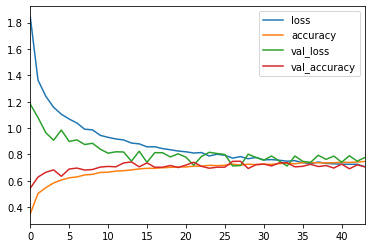

In [35]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [43]:
predictions = model.predict_classes(X_test)
pred_proba = model.predict(X_test)
final_proba = np.amax(pred_proba,axis=1)
print(final_proba)

[0.95207626 0.77002347 0.6801587  ... 0.7039403  0.96439236 0.31578395]


[[0.22172172 0.25376271 0.43091382 ... 0.69923709 0.         0.        ]
 [0.34834835 0.21885781 0.32877454 ... 0.93633634 0.76492029 0.68208159]
 [0.77827828 0.60356147 0.88088088 ... 0.94802495 0.655361   0.48466125]
 ...
 [0.86236236 0.98590961 0.84331909 ... 0.         0.         0.        ]
 [0.14364364 0.90682107 0.18965696 ... 0.         0.         0.        ]
 [0.18468468 0.61227655 0.42704701 ... 0.6041041  0.         0.        ]]


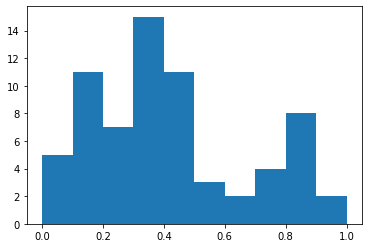

In [37]:
for x,y in training_generator:
    print(x)
    plt.hist(x[:,2])
    '''letter_counts = Counter(y)
    print(letter_counts)
    df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
    df_hist.plot(kind='bar')'''
    break
    

In [38]:


print("Accuracy:", metrics.accuracy_score(y_test_original, predictions))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test_original, predictions))

#Dumping trained model

features_list = list(X_train_original)


Accuracy: 0.7033430558671753
Balanced accuracy: 0.608693839566278


In [39]:
print(y_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[1476  261   43   14    6    0    0    0    2    0    0    0    0    0
     0    0    2]
 [  60  344   12    1    3    3    0    2    2    0    0    0    0    0
     1    1    0]
 [  33   30  108    4    6    0    0    1    0    0    0    0    0    0
     0    0    0]
 [   1    1    3  125    2    6    1    1    0    0    2    7    5    0
     1    0    1]
 [   2    1    4    5  179    0    0    0    0    1    0    0    0    4
    10   11    4]
 [   0    1    0    0    0  115    8    8    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    5    3    1    0    0    0    0    0    0
     0    0    0]
 [   0    2    0    1    0   10    4   20    1    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    1    3    0    0    0    0    0    0
     0    0    0]
 [  18    5    8   62   50    0    0    1    0 1640 1829  337  104   29
     8  357  591]
 [   1    1    1   17   15    0    0    0    0  161  857   73   26   14
     4   92   91]
 [   0    

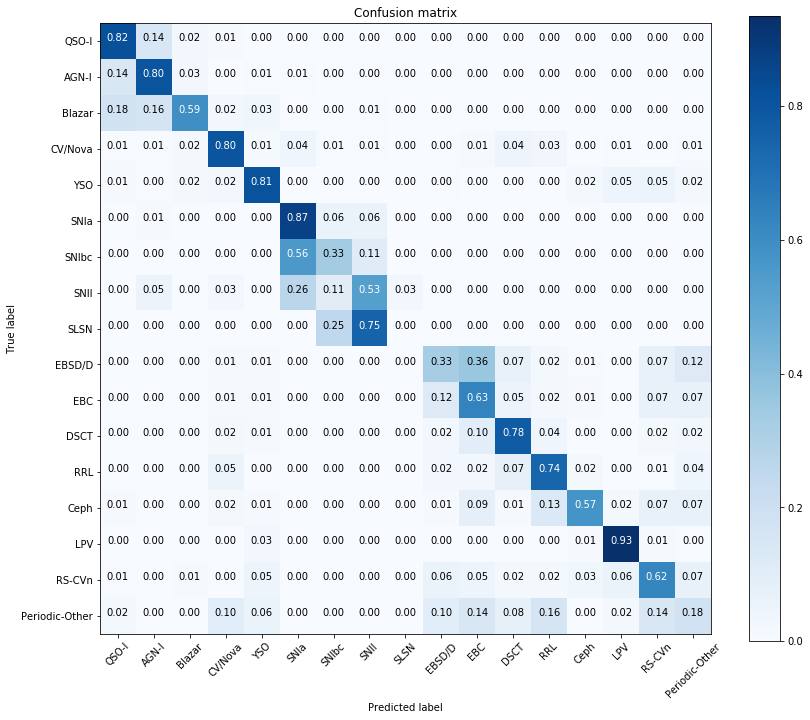

In [40]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(le.inverse_transform(y_test_original), le.inverse_transform(predictions), labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order,conf_matrix_name)

In [55]:
# Kaggle score

CLASSES_REDUCED_V2 = label_order


class_weights = list(class_weight.compute_class_weight('balanced', le.transform(label_order), y_test_original))


def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = le.transform(CLASSES_REDUCED_V2)#np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(y_test_original,pred_proba,class_weights))

EBSD/D -0.1654189262048302
QSO-I -0.47214775632285105
AGN-I -2.9210226445977425
Blazar -5.579459045537456
Periodic-Other -14.367646622307161
LPV -0.07836002390706784
RS-CVn -33.004519357216246
Ceph -20.23880413273716
RRL -1.620973471541203
SNIbc -194.94824158599954
SNIa -10.466831356233879
YSO -5.246579158820146
EBC -0.8231560984832671
CV/Nova -10.582928285115084
SNII -8.47420074380127
DSCT -12.655705007526139
SLSN -1245.3071220657405
2.6064836721888596


  ## Classifying unlabeled data

In [61]:
#loading the data

print(df_feat.n_samples_1.size)
print(rm_nd_cols)

#rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
#             'Mean_1','Mean_2','paps_non_zero_1','paps_non_zero_2']

'''rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'Mean_1',
'Mean_2',
'paps_non_zero_1',
#'paps_PN_flag_1',
'paps_non_zero_2',
#'paps_PN_flag_2',
]'''

mean_drop = ['Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul = df_feat_ul.drop(mean_drop, axis=1)
#df_feat_ul = df_feat_ul.join(df_wise.drop(wise_drop, axis=1))
df_feat_ul = df_feat_ul.replace([np.inf, -np.inf], np.nan)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

df_feat_ul.head()



653905
['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'paps_non_zero_1', 'paps_non_zero_2', 'W1', 'W2', 'W3', 'W4', 'u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'i_z']
653905


,n_samples_1,Amplitude_1,AndersonDarling_1,Autocor_length_1,Beyond1Std_1,Con_1,Eta_e_1,Gskew_1,MaxSlope_1,Meanvariance_1,...,paps_ratio_1,paps_ratio_2,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaaaal,5.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-1.493229,1.000000,0.500000,0.626905,1.000000,-0.089,0.912,2.997933,2.085933
ZTF17aaaaaam,0.0,-999.000000,-999.0,-999.0,-999.000000,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,...,-999.000000,-999.000000,-999.000000,0.083333,0.635476,0.987167,0.038,0.565,5.909550,5.344550
ZTF17aaaaaan,57.0,0.259178,1.0,1.0,0.385965,0.0,2.666081,-0.081434,0.488864,0.011620,...,7.003891,-2.943499,0.459016,0.172414,0.730000,1.000000,-0.160,0.893,3.745013,2.852013
ZTF17aaaaaao,32.0,0.238777,1.0,1.0,0.343750,0.0,0.651816,-0.104300,0.173520,0.007609,...,33.561080,-0.202701,0.156250,0.325581,0.776667,0.999167,0.014,1.623,4.135574,2.512574
ZTF17aaaaaas,77.0,0.383210,1.0,1.0,0.155844,0.0,1.490287,0.628897,0.875627,0.012610,...,1.285452,15.110684,0.844156,0.000000,0.838333,0.996667,0.006,1.001,4.327510,3.326510


In [66]:
#predicting classes of unlabeled data

x_test_scaled = scaler.transform(df_feat_ul)
print(x_test_scaled.shape)
test_Y = le.inverse_transform(model.predict_classes(x_test_scaled))
test_Y_proba = model.predict(x_test_scaled)

(653905, 136)


In [75]:
print(np.amax(test_Y_proba,axis=1))

[0.6254126  0.9163634  0.43888327 ... 0.83531475 0.6445431  0.5230409 ]


In [76]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)

df_out['predicted_class'] = test_Y
df_out['predicted_class_proba'] = np.amax(test_Y_proba,axis=1)
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

(653905, 138)


"\nprobs_header = prob_final_class_names_ul + '_prob'\n\nprob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)\n\nprob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)\n\ntest_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)\n\ntest_data_withclass.to_csv(class_output)\n\ntest_data_withclass.head()\n"

In [77]:
test_data_withclass.shape
#class_final_name_ul = le_original.inverse_transform(class_final_name_ul)

(653905, 138)

Text(0.5, 1.0, 'sources classified')

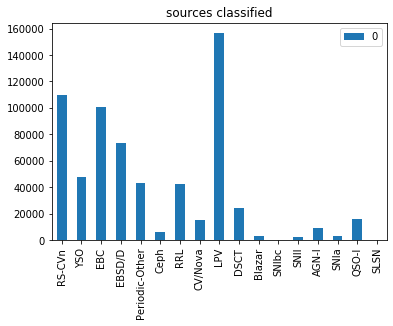

In [70]:
letter_counts = Counter(test_Y)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')


0 QSO-I 0.6762932240962982
1 AGN-I 0.6730431914329529
2 Blazar 0.5369477570056915
3 CV/Nova 0.4726859927177429
4 YSO 0.5822682082653046
5 SNIa 0.9037794470787048
6 SNIbc 0.7219290137290955
7 SNII 0.6042834222316742
8 SLSN 0.9189853966236115
9 EBSD/D 0.41994306445121765
10 EBC 0.4991501271724701
11 DSCT 0.4996899962425232
12 RRL 0.6661012470722198
13 Ceph 0.5071356892585754
14 LPV 0.9128401577472687
15 RS-CVn 0.5675024390220642
16 Periodic-Other 0.436637282371521


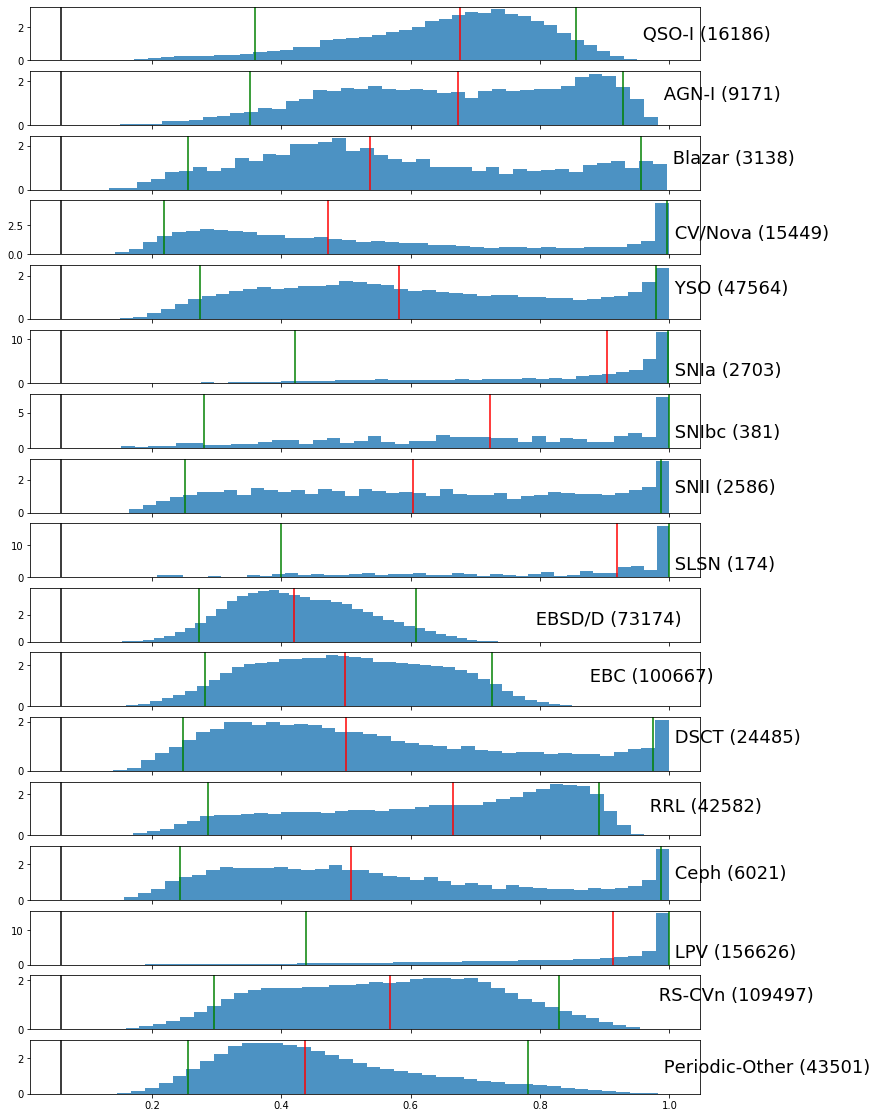

In [78]:

fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

0 QSO-I 0.11459617685430068
1 AGN-I 0.1568970179563518
2 Blazar 0.3936305181058977
3 CV/Nova -0.025153739921998763
4 YSO 1.6561184274155991
5 SNIa 0.010153095444898952
6 SNIbc 0.42910861968995023
7 SNII 0.1709003448486488
8 SLSN 0.15327644348140268
9 EBSD/D 0.547338835339902
10 EBC 0.5682365305430022
11 DSCT 0.0373906900739982
12 RRL 0.0596858587444018
13 Ceph 0.7970160313865993
14 LPV 2.2658560465057516
15 RS-CVn 0.8990823419966016
16 Periodic-Other 0.4781691601197995


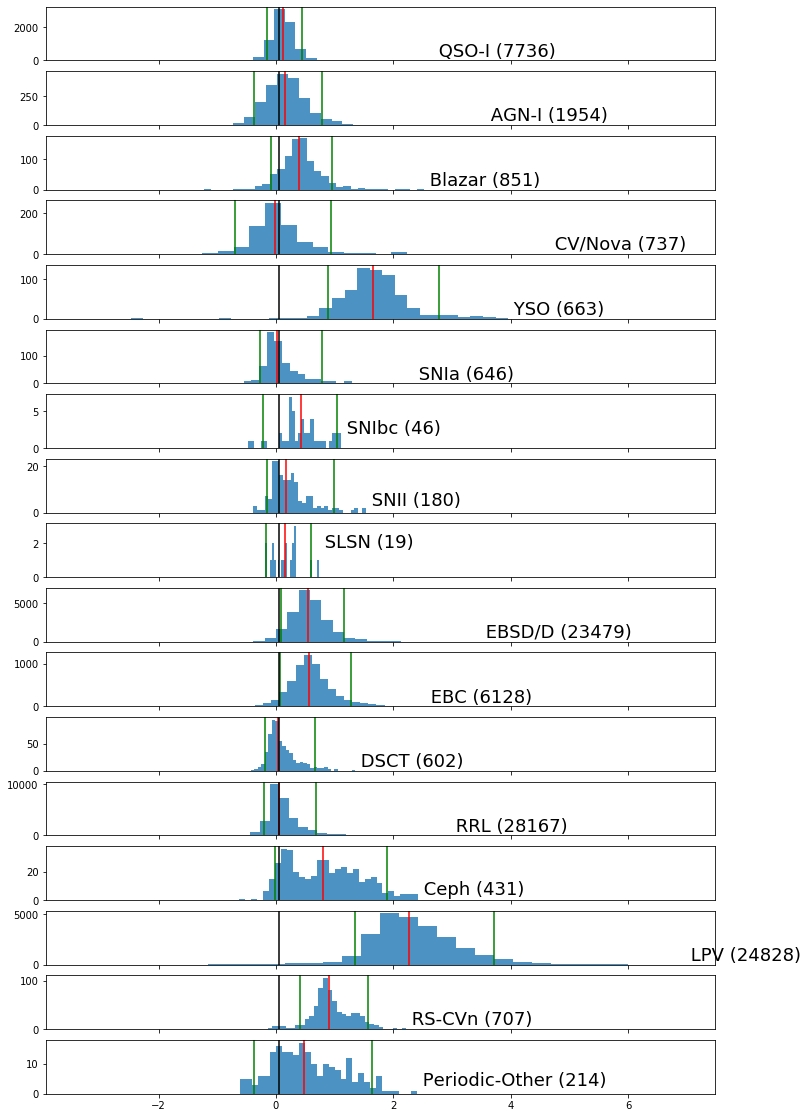

In [80]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train#.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(label_order), c = 'k')
   if logscale: 
      feat = np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values)
      feat = feat[feat>0]
      ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=30, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=30, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

QSO-I 12775
AGN-I 7392
Blazar 2893


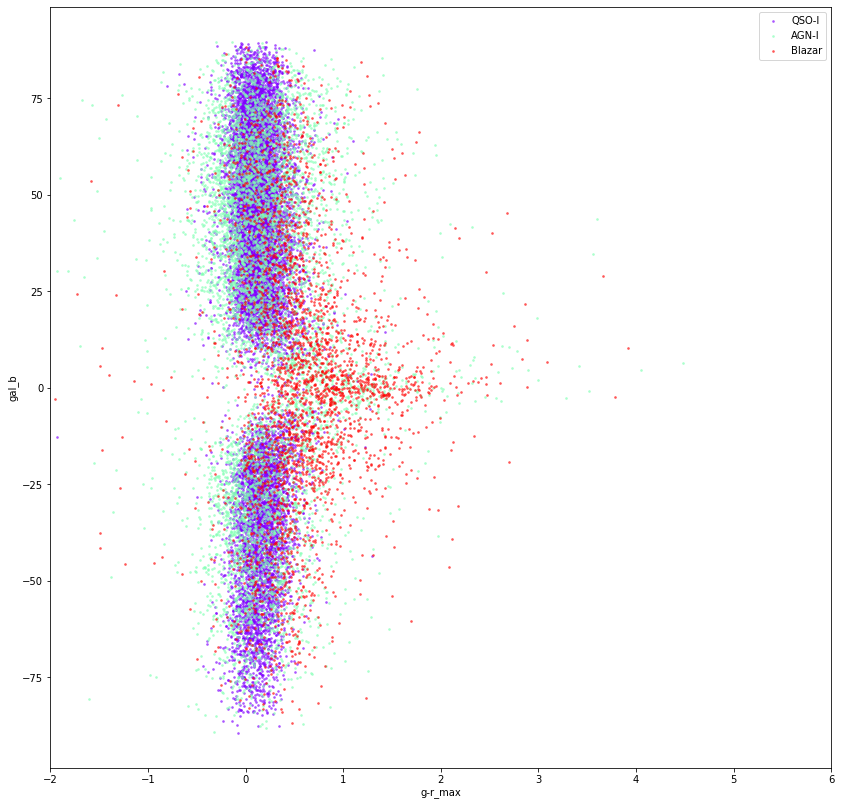

In [84]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   print(cl,len(df_test[feature_x][df_test['predicted_class']==cl].values))
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.xlabel('g-r_max')
plt.ylabel('gal_b')
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

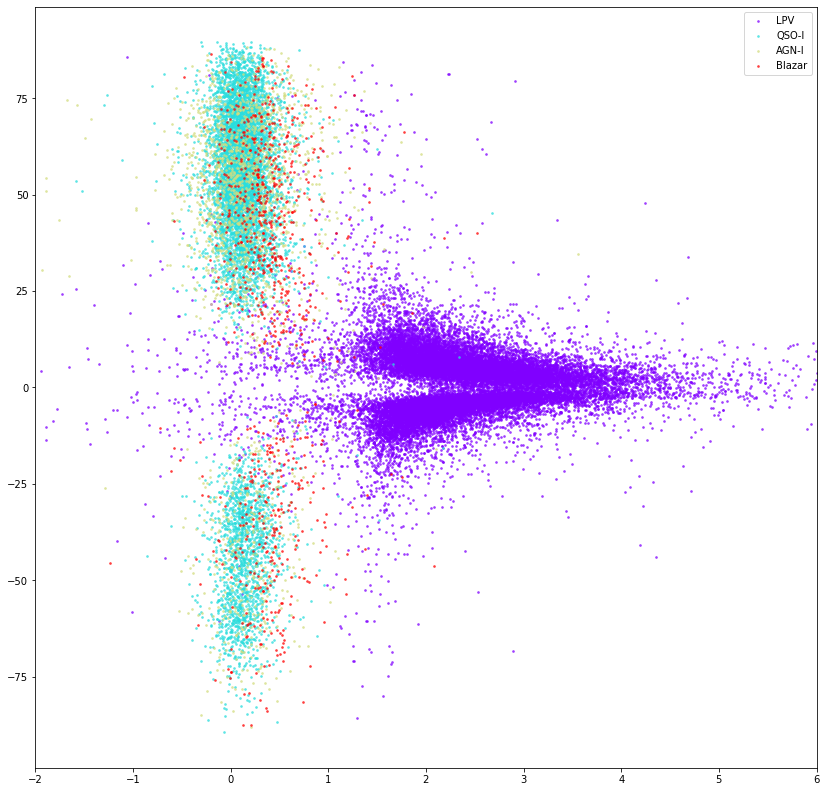

In [83]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,s = 3,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')